# What happens if we multiply one term by $\alpha$ ?

In [7]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings

warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
from histlib.diagnosis import (
    build_matchup_dataframe,
    synthetic_figure,
    path_csv,
    put_fig_letter,
    lonlat_stats,
    build_diagnostic,
)
from histlib.cstes import labels, zarr_dir, matchup_dir, U

U2 = U**2

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster

    # cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    # cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=5, processes=5, walltime="00:15:00")
    w = cluster.scale(jobs=4)
    # w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.251:8787/status,
Dashboard: http://10.148.0.251:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.251:57285,Workers: 0
Dashboard: http://10.148.0.251:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [31]:
cluster.close()

# Preparation

In [24]:
alpha2 = 1.5
alpha0 = 0.5
tm = "wd"

In [25]:
DL, DT = 25e3, 30 * 60
# if not already generated
comb = {
    "acc": "drifter_acc_x_25",
    "cor": "drifter_coriolis_x_25",
    "ggx": "alti_ggx_adt_filtered_ocean_tide_internal_tide",
    "wd": "es_cstrio_z15_drifter_wd_x",
}

df = (
    dd.read_csv(path_csv(comb, "both", True, DL, DT))
    .repartition(npartitions=10)
    .persist()
)

In [26]:
df0 = df.copy()
df2 = df.copy()
df0[tm] = df0[tm] * alpha0
df2[tm] = df2[tm] * alpha2
df0 = build_diagnostic(df0, comb, rename=True)
df2 = build_diagnostic(df2, comb, rename=True)

In [27]:
def global_stast(df):
    from histlib.cstes import U

    # Mean
    mean = df.mean().compute()
    nb_coloc = len(df)
    mean["nb_coloc"] = nb_coloc

    # Central limit theorem
    errors = (2 * df.std() / np.sqrt(nb_coloc)).compute()

    df = pd.DataFrame([mean, errors], index=["value", "errors"]).transpose() / (U**2)

    df["percentage"] = df.value / df.value.sigma * 100
    df["percentage_erros"] = df.percentage * np.sqrt(
        (df.errors / df.value) ** 2 + (df.errors.sigma / df.value.sigma) ** 2
    )

    return df

In [28]:
d0 = global_stast(df0)
d = global_stast(df)
d2 = global_stast(df2)

# Impact of scaling error

In [29]:
d0.loc["S"].value, d.loc["S"].value, d2.loc["S"].value

(1.6566694850002903, 1.6380933581416872, 1.7042056519600426)

In [35]:
(d0.loc["S"].value - d.loc["S"].value) / d.loc["S"].value * 100, (
    d2.loc["S"].value - d.loc["S"].value
) / d.loc["S"].value * 100

(1.1340090457162062, 4.035929545148487)

8.256777642584227
8.418208753028015
8.383810273600547
8.616672494488125
8.595531325292837
8.899824656624201


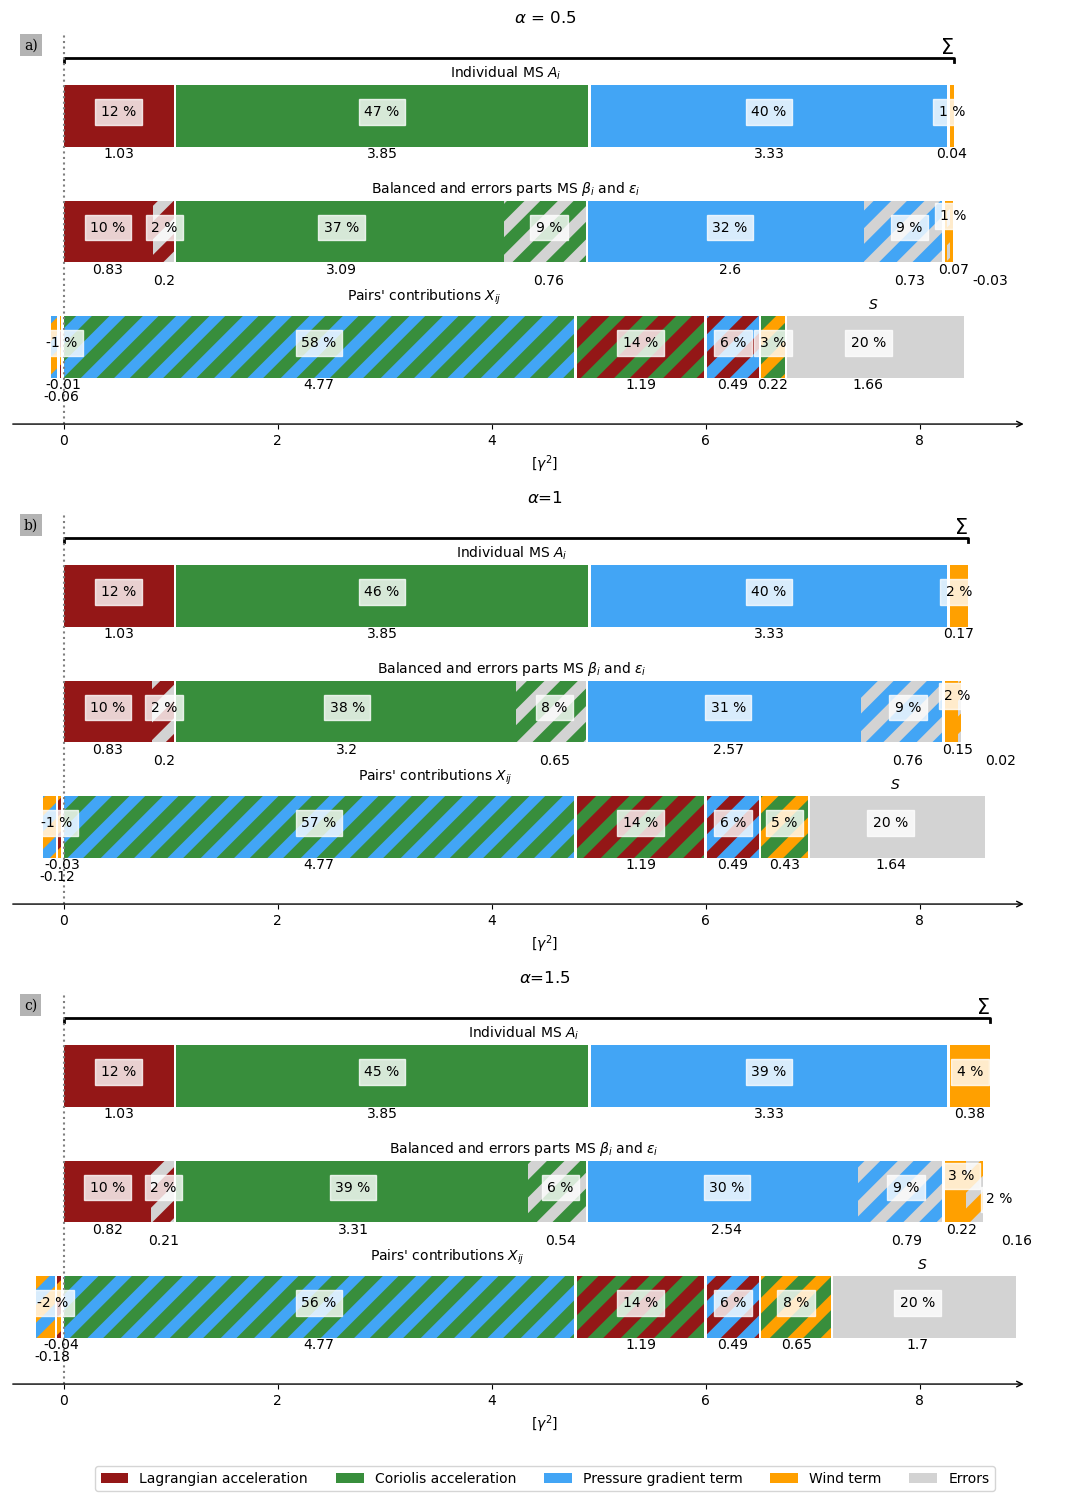

In [38]:
fig, axs = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(11, 15),
    frameon=False,
)
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(d0.value, axs[0], xlim=9)
synthetic_figure(d.value, axs[1], xlim=9)
synthetic_figure(d2.value, axs[2], xlim=9)

axs[0].set_title(r"$\alpha$ = 0.5")
axs[1].set_title(r"$\alpha$=1")
axs[2].set_title(r"$\alpha$=1.5")

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(fig, axs[0], "a")
put_fig_letter(fig, axs[1], "b")
put_fig_letter(fig, axs[2], "c")
fig.legend(handles, labels, ncol=5, loc="lower center")
fig.tight_layout(rect=[0, 0.03, 1, 1])  # left, bottom, right, top (default is 0,0,1,1)
# fig.savefig('../images_all/synth_samex.png',bbox_inches='tight',   dpi=300)
# fig.savefig('../images_all/synth_samex.jpeg',bbox_inches='tight',   dpi=300)

# Verify theory

$ d_k = (\alpha -1)a_k $

$$ S^* - S  = (\alpha^2 -1)A_k+ 2(\alpha -1)\sum_{j\neq k}\langle a_k a_j \rangle $$ 

For i $\neq$ k :
$$ \beta_i^*- \beta_i = (1-\alpha)\langle a_i a_k \rangle $$ 
$$ \epsilon_i^* -\epsilon_i = -(1-\alpha)\langle a_i a_k \rangle $$
For i=k : 
$$ \beta_i^*- \beta_i = (1-\alpha)\langle a_i a_k \rangle $$
$$ \epsilon_i^* -\epsilon_i = -(1-\alpha)\langle a_i a_k \rangle $$



In [52]:
(alpha0**2 - 1) * d.loc["WD"].value + 2 * (alpha0 - 1) * (
    d.value[["acc_wd", "cor_wd", "ggx_wd"]].sum()
)

0.018576126858702025

In [45]:
d0.loc["S"].value - d.loc["S"].value

0.018576126858603104

In [66]:
cluster.close()